# Inference with a Cellpose model:

In [1]:
# !pip install --no-index ../input/cellposewheels/cellpose-0.7.2-py3-none-any.whl --find-links=../input/cellposewheels/

In [2]:
%%writefile run.py
import numpy as np
import cv2
from cellpose import io, plot
from cellpose.models import CellposeModel
from fastai.vision.all import load_learner
from pathlib import Path
import pandas as pd

def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

test_dir = Path('../input/sartorius-cell-instance-segmentation/test')
test_files = [fname for fname in test_dir.iterdir()]

models = {}

models['astro'] = CellposeModel(
    gpu=True, 
    pretrained_model=[
        '../input/30diamastropretrainnoastro/cellpose_residual_on_style_on_concatenation_off_train_by_type_2021_12_26_10_04_13.239808_epoch_1999'
    ]
)

models['cort'] = CellposeModel(
    gpu=True, 
    pretrained_model=[
        '../input/cellpose-diam19-shsy5y-no-astro-add-4000ep/cellpose_residual_on_style_on_concatenation_off_diam19_no_astro_add_2021_12_28_08_11_44.186409_epoch_1001',
        '../input/cellpose-diam19-shsy5y-2000ep/cellpose_residual_on_style_on_concatenation_off_train_2021_12_21_08_51_19.563849_epoch_1999',
    ]
)

models['shsy5y'] = CellposeModel(
    gpu=True, 
    pretrained_model=[
        '../input/cellpose-diam19-shsy5y-no-astro-add-4000ep/cellpose_residual_on_style_on_concatenation_off_diam19_no_astro_add_2021_12_28_08_11_44.186409_epoch_1001',
        '../input/cellpose-diam19-shsy5y-2000ep/cellpose_residual_on_style_on_concatenation_off_train_2021_12_21_08_51_19.563849_epoch_1999',
    ]
)

learner = load_learner('../input/cellpose-classifier/cell-classification-learner.pkl')

diam_dict = {
    'shsy5y': 25,
    'astro': 28,
    'cort': 30
}

df_train = pd.read_csv(r"../input/sartorius-cell-instance-segmentation/train.csv")
df_train['n_pixels'] = df_train.annotation.apply(lambda x: np.sum([int(e) for e in x.split()[1:][::2]]))
df_pixels = df_train \
    .groupby("cell_type")[['n_pixels']] \
    .describe(percentiles=[0.02, 0.05, 0.1, 0.9, 0.95, 0.98]) \
    .astype(int).T.droplevel(level=0) \
    .T.drop(['count', '50%', 'std'], axis=1)


ids, masks = [],[]
for j, fn in enumerate(test_files):
    t_image = io.imread(str(fn))
    pred_type = learner.predict(str(fn))[0]
    preds, flows, _ = models[pred_type].eval(
        t_image, diameter=None, channels=[0, 0], augment=True, resample=False, omni=False,
        min_size=-1
    )
    
    used = np.zeros(preds.shape, dtype=int)
    for i in range (1, preds.max() + 1):
        
        t_preds = (preds == i).astype(int)
        t_preds *= (1 - used)
        
        if t_preds.sum() >= df_pixels.loc[pred_type, '2%']:
            ids.append(fn.stem)
            used += t_preds
            masks.append(rle_encode(t_preds))


pd.DataFrame({'id':ids, 'predicted':masks}).to_csv('submission.csv', index=False)

Writing run.py


In [3]:
!python run.py

creating new log file


In [4]:
import pandas as pd

subm = pd.read_csv('submission.csv')
subm.head(20)

,id,predicted
0,7ae19de7bc2a,65 4 752 5 765 10 1456 23 2160 23 2864 22 3568...
1,7ae19de7bc2a,524 5 1225 11 1928 13 2631 14 3335 15 4039 15 ...
2,7ae19de7bc2a,570 6 1270 16 1973 19 2676 21 3380 21 4085 21 ...
3,7ae19de7bc2a,1151 7 1854 9 2558 10 3262 11 3966 12 4670 12 ...
4,7ae19de7bc2a,1204 11 1905 16 2608 17 3311 18 4015 18 4718 1...
5,7ae19de7bc2a,3370 10 4070 15 4771 18 5474 20 6178 21 6882 2...
6,7ae19de7bc2a,7792 1 8496 5 9199 9 9902 12 10605 13 11308 13...
7,7ae19de7bc2a,9822 1 10524 5 11226 8 11929 10 12633 11 13336...
8,7ae19de7bc2a,13359 2 14061 5 14764 7 15466 10 16168 12 1687...
9,7ae19de7bc2a,14019 10 14719 18 15419 24 16123 26 16828 26 1...


In [5]:
subm['id'].unique()

array(['7ae19de7bc2a', 'd8bfd1dafdc4', 'd48ec7815252'], dtype=object)

In [6]:
SIZE = (int(520*1.), int(704*1.))

In [7]:
def plot_masks(image_id, colors=True):
    labels = subm[subm["id"] == image_id]["predicted"].tolist()

    if colors:
        mask = np.zeros((SIZE[0], SIZE[1], 3))
        for label in labels:
            mask += rle_decode(label, shape=(SIZE[0], SIZE[1], 3), color=np.random.rand(3))
    else:
        mask = np.zeros((SIZE[0], SIZE[1], 1))
        for label in labels:
            mask += rle_decode(label, shape=(SIZE[0], SIZE[1], 1))
    mask = mask.clip(0, 1)
    

    image = cv2.imread(f"../input/sartorius-cell-instance-segmentation/test/{image_id}.png")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(16, 32))
    plt.subplot(3, 1, 1)
    plt.imshow(image)
    plt.title('Input image')
    plt.axis("off")
    plt.subplot(3, 1, 2)
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
    plt.title('Input image with mask')
    plt.axis("off")
    plt.subplot(3, 1, 3)
    plt.imshow(mask)

    plt.title('Only mask')
    plt.axis("off")
    
    plt.show();

In [8]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height, width, channels) of array to return 
    color: color for the mask
    Returns numpy array (mask)

    '''
    s = mask_rle.split()
    
    starts = list(map(lambda x: int(x) - 1, s[0::2]))
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]
    
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
            
    for start, end in zip(starts, ends):
        img[start : end] = color
    
    return img.reshape(shape)

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

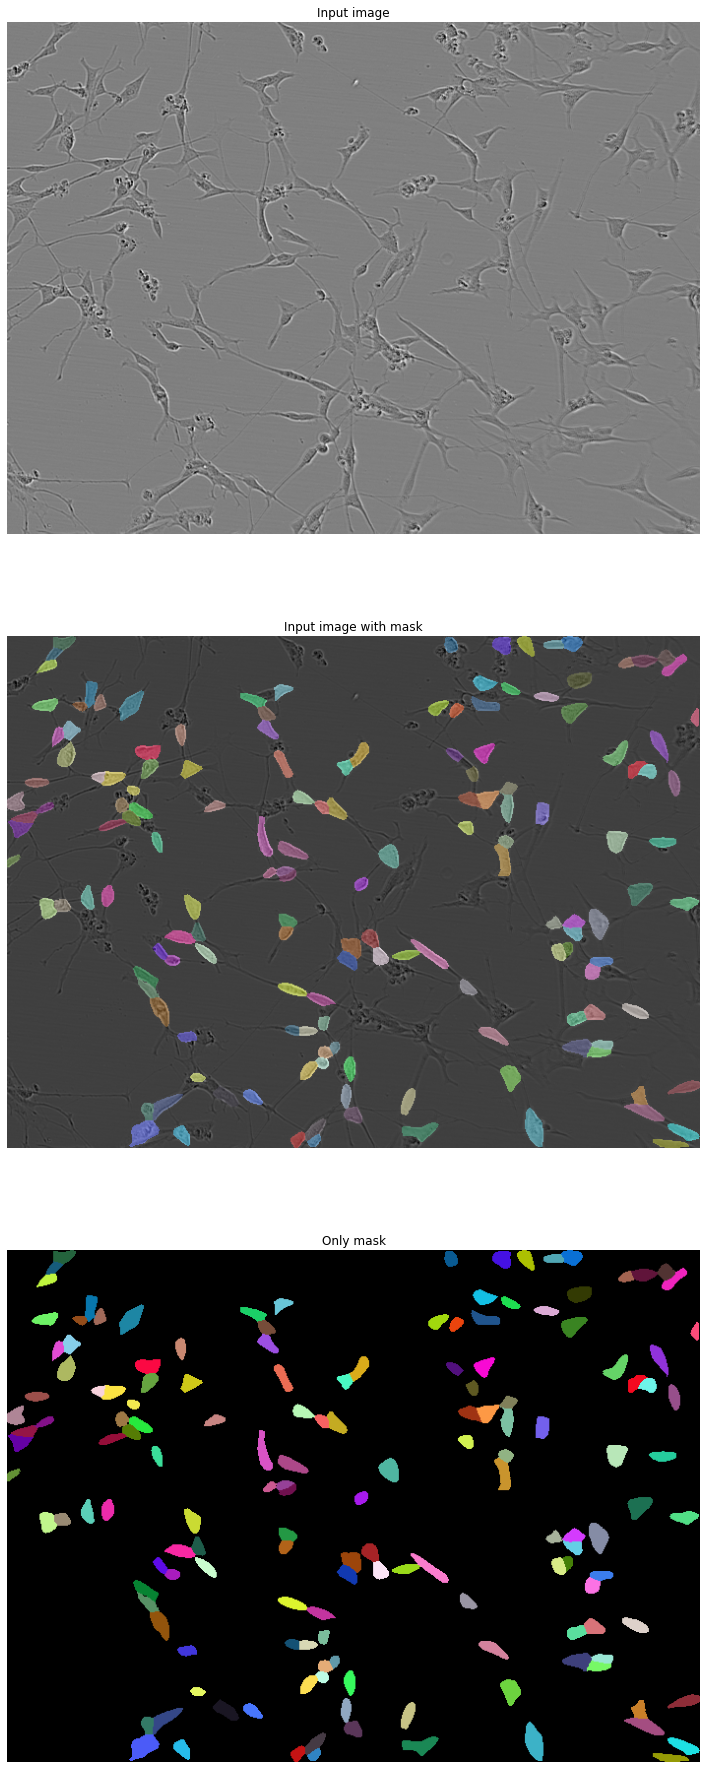

In [10]:
plot_masks('7ae19de7bc2a')